<a href="https://colab.research.google.com/github/bhushanrajs/distribution_factors_pySR/blob/main/df_PySR_PSC_BM_G2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Symbolic Regression

In [1]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.5"
export JULIA_PKG_PRECOMPILE_AUTO=0
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  echo "Installing PyCall.jl..."
  julia -e 'using Pkg; Pkg.add("PyCall"); Pkg.build("PyCall")'
  julia -e 'println("Success")'

fi

Installing Julia 1.8.5 on the current Colab Runtime...
2024-06-12 20:33:38 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.8/julia-1.8.5-linux-x86_64.tar.gz [130873886/130873886] -> "/tmp/julia.tar.gz" [1]
Installing PyCall.jl...
  Installing known registries into `~/.julia`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed VersionParsing ── v1.3.0
   Installed Conda ─────────── v1.10.0
   Installed MacroTools ────── v0.5.13
   Installed JSON ──────────── v0.21.4
   Installed Preferences ───── v1.4.3
   Installed Parsers ───────── v2.8.1
   Installed PrecompileTools ─ v1.2.1
   Installed PyCall ────────── v1.96.4
    Updating `~/.julia/environments/v1.8/Project.toml`
  [438e738f] + PyCall v1.96.4
    Updating `~/.julia/environments/v1.8/Manifest.toml`
  [8f4d0f93] + Conda v1.10.0
  [682c06a0] + JSON v0.21.4
  [1914dd2f] + MacroTools v0.5.13
  [69de0a69] + Parsers v2.8.1
  [aea7be01] + PrecompileTools v1.2.1
  [21216c

Install PySR and PyTorch-Lightning:

In [2]:
%pip install -Uq pysr pytorch_lightning --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.3/76.3 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.3/802.3 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 44.6 MB/s eta 0:00:00


In [3]:
%pip install julia

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.2 MB/s eta 0:00:00


In [4]:
from julia import Julia

julia = Julia(compiled_modules=False, threads="auto")
from julia import Main
from julia.tools import redirect_output_streams

redirect_output_streams()

In [ ]:
import pysr

# We don't precompile in colab because compiled modules are incompatible static Python libraries:
pysr.install(precompile=False)

[juliapkg] Found dependencies: /usr/local/lib/python3.10/dist-packages/juliacall/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.10/dist-packages/pysr/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.10/dist-packages/juliapkg/juliapkg.json
[juliapkg] Locating Julia ~1.6.7, ~1.7, ~1.8, ~1.9, =1.10.0, ^1.10.3
[juliapkg] Using Julia 1.8.5 at /usr/local/bin/julia
[juliapkg] Using Julia project at /root/.julia/environments/pyjuliapkg
[juliapkg] Installing packages:
           julia> import Pkg
           julia> Pkg.Registry.update()
           julia> Pkg.add([Pkg.PackageSpec(name="PythonCall", uuid="6099a3de-0909-46bc-b1f4-468b9a2dfc0d"), Pkg.PackageSpec(name="SymbolicRegression", uuid="8254be44-1295-4e6a-a16d-46603ac705cb"), Pkg.PackageSpec(name="Serialization", uuid="9e88b42a-f829-5b0c-bbe9-9e923198166b")])
           julia> Pkg.resolve()
           julia> Pkg.precompile()


In [1]:
import sympy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [198]:
df = pd.read_csv('https://raw.githubusercontent.com/bhushanrajs/distribution_factors_pySR/main/skew_0.csv')

In [199]:
print(df.head(5))

                             model girderName     L     D  w_oh    ts    S  \
0   Tx28-L_42-Nb_4-S_60-O_15-ts_85       Tx28  42.0  28.0   1.5   8.5  6.0   
1  Tx28-L_42-Nb_4-S_60-O_15-ts_100       Tx28  42.0  28.0   1.5  10.0  6.0   
2   Tx28-L_42-Nb_4-S_60-O_20-ts_85       Tx28  42.0  28.0   2.0   8.5  6.0   
3  Tx28-L_42-Nb_4-S_60-O_20-ts_100       Tx28  42.0  28.0   2.0  10.0  6.0   
4   Tx28-L_42-Nb_4-S_60-O_25-ts_85       Tx28  42.0  28.0   2.5   8.5  6.0   

    Nb     n_bm1     n_bm2  ...     n_bm4      n_r1      n_r2      n_r3  \
0  4.0  0.554060  0.293421  ...  0.000520  0.925505  0.086994  0.026596   
1  4.0  0.534037  0.298249  ...  0.000889  0.923853  0.093144  0.036185   
2  4.0  0.586017  0.279188  ...  0.000448  0.993568  0.023006  0.024837   
3  4.0  0.563802  0.286541  ...  0.000803  0.991692  0.031001  0.033527   
4  4.0  0.617704  0.265168  ...  0.000379  1.060984 -0.039607  0.022209   

       n_r4    sum_RY      d-G1      d-G2      d-G3          d-G4  
0 -0.039095 

In [201]:

L = df['L']
D = df['D']
S = df['S']
w_oh = df['w_oh']
ts = df['ts']
Nb = df['Nb']
LR = w_oh/S
LD = L/D

n_bm1 = df['n_bm1']
n_bm2 = df['n_bm2']
n_r1 = df['n_r1']
n_r2 = df['n_r2']

In [ ]:
# sample data from lever rule
# n_r1 = (w_oh + S) / S

In [202]:
X = np.stack((L, w_oh, S, D, Nb, L/D), axis=-1)
y = n_bm2

In [203]:
# Learn equations
default_pysr_params = dict(
    populations=50,
    model_selection="best",
)

# model = PySRRegressor(
#     niterations=30,
#     binary_operators=['+', '-', '*', '/', '^'],
#     unary_operators=["square", "cube", "sqrt"],
#     **default_pysr_params
# )

model = PySRRegressor(
    niterations=200,  # < Increase me for better results
    binary_operators=['+', '-', '*', '/', '^', "physics(x, y) = x^2 / y"],
    unary_operators=["square", "cube", "sqrt", "inv(x) = 1/x"],
        # ^ Custom operator (julia syntax)
    extra_sympy_mappings={"inv": lambda x: 1 / x,
                          "physics": lambda x, y: x**2 / y},
    # ^ Define operator for SymPy as well
    loss="loss(prediction, target) = (prediction - target)^2",
    constraints = {'^':(-1,1),'mult' : (3,3)},
    # ^ Custom loss function (julia syntax)
    **default_pysr_params
)

model.fit(X, y)

print(model)

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:870: FutureWarning: loss has been renamed to elementwise_loss in PySRRegressor. Please use that instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1307: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!


Streaming output truncated to the last 5000 lines.
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 2.090e+04
Head worker occupation: 10.8%
Progress: 2208 / 10000 total iterations (22.080%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           3.505e-02  1.594e+01  y = 0.46924
2           2.380e-03  2.690e+00  y = square(0.5371)
4           1.949e-03  9.976e-02  y = 0.20402 * sqrt(x₅)
5           1.235e-03  4.566e-01  y = 0.38995 - (x₂ / x₀)
6           1.219e-03  1.260e-02  y = cube(0.69359 - (x₁ / x₀))
7           4.484e-04  1.000e+00  y = 0.32643 - physics(x₂, physics(x₀, x₁))
8           4.464e-04  4.445e-03  y = square(0.57345 - physics(x₂, physics(x₀, x₁)))
9           4.431e-04  7.329e-03  y = 0.32764 - physics(x₂, physics(x₀, x₁) 

In [217]:
model.sympy(5)

0.3264262 - x1*x2**2/x0**2

In [219]:
n_bm2_pred = model.predict(X,5)

print("Default selection MSE:", np.power(n_bm2_pred - y, 2).mean())

Default selection MSE: 1.3759546294979742e-05


<ipython-input-220-73d9a4514cc3>:32: UserWarning: You passed a edgecolor/edgecolors ('b') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x, y, marker='x', c='b', edgecolor='b', label='Interior Girder')


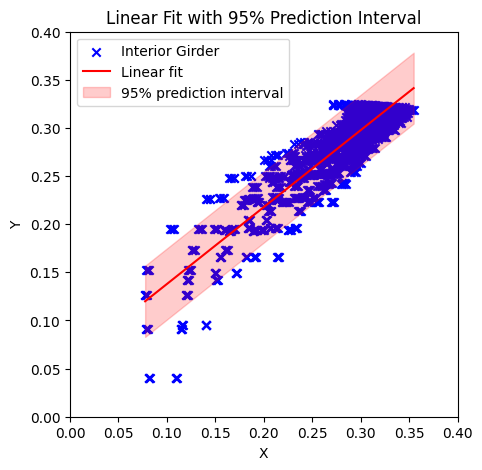

In [220]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Generate some example data
x = n_bm2
y = n_bm2_pred

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Calculate the regression line
line = slope * x + intercept

# Sort the values for proper shading
sort_idx = np.argsort(x)
x_sorted = x[sort_idx]
line_sorted = line[sort_idx]

# Calculate the prediction interval
mean_x = np.mean(x)
n = len(x)
t = stats.t.ppf(0.975, n - 2)
sum_errs = np.sum((y - line) ** 2)
stdev = np.sqrt(1/(n-2) * sum_errs)

# Prediction interval calculation
pi = t * stdev * np.sqrt(1 + 1/n + (x_sorted - mean_x)**2 / np.sum((x_sorted - mean_x)**2))

# Plot the scatter plot, regression line, and prediction intervals
plt.figure(figsize=(5, 5))
plt.scatter(x, y, marker='x', c='b', edgecolor='b', label='Interior Girder')
plt.plot(x_sorted, line_sorted, color='red', label='Linear fit')
plt.fill_between(x_sorted, line_sorted - pi, line_sorted + pi, color='red', alpha=0.2, label='95% prediction interval')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Linear Fit with 95% Prediction Interval')
plt.legend()
plt.xlim((-0.0,0.4))
plt.ylim((-0.0,0.4))
plt.show()




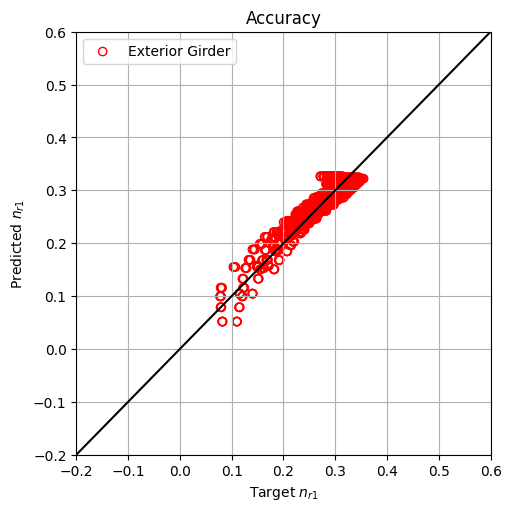

In [34]:
x_line = [-0.2, 0.6]
y_line = [-0.2, 0.6]

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout = True)

ax1.scatter(x=n_bm2, y=n_bm2_pred, marker='o', c='none', edgecolor='r', label='Exterior Girder')
ax1.plot(x_line, y_line, c = "k")
ax1.set_title('Accuracy')
ax1.legend()
plt.xlim((-0.2,0.6))
plt.ylim((-0.2,0.6))
ax1.set_xlabel('Target $n_{r1}$')
ax1.set_ylabel('Predicted $n_{r1}$')
ax1.grid()